In [1]:
#Import packages
import tensorflow as tf
import tensorflow_datasets as tfds

/Users/houhiroshisakai/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/houhiroshisakai/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Load Dataset
(ds_train, ds_val, ds_test), ds_info = tfds.load(name="stanford_dogs", 
                                     split=['train[:80%]+test[:80%]','train[80%:90%]+test[80%:90%]', 'train[90%:]+test[90%:]'],
                                     shuffle_files=True,
                                     as_supervised=True,
                                     with_info=True)

In [3]:
#Identify the number of classes
ds_info.features['label'].num_classes

120

In [4]:
#Image Augmentation
augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                        tf.keras.layers.RandomRotation(0.1),
                                        tf.keras.layers.RandomContrast(factor=0.1),
                                        ])

In [5]:
#Image Preprocessing
#Resize the image & Define one-hot encode labels
def preprocess1(image, label):
  label = tf.one_hot(label,120)
  image = tf.image.resize(images=image, size=[224, 224])
  return image, label
#Preprocessing image so that the model can match the inception model
def preprocess2(image, label):
  return tf.keras.applications.inception_resnet_v2.preprocess_input(tf.cast(image, tf.float32)), label

In [6]:
#Apply Preprocessing to train/validation/test dataset
ds_train = ds_train.map(preprocess1, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.map(preprocess2, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(64, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)


ds_val = ds_val.map(preprocess1, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.map(preprocess2, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.batch(64, drop_remainder=True)
ds_val = ds_val.cache()
ds_val = ds_val.prefetch(tf.data.AUTOTUNE)


ds_test = ds_test.map(preprocess1, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess2, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(64, drop_remainder=True)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [7]:
def create_model():
  #Define the input layer w/ the shape of the images
  inputs = tf.keras.layers.Input(shape=(224,224,3))
  #Apply the image augmentation
  x = augmentation(inputs)

  #Load InceptionResNetV2 Model, and pre-trained on ImageNet
  #Ignore the classification layer of the model
  base = tf.keras.applications.InceptionResNetV2(input_tensor=x,
                                                input_shape=(224,224,3),
                                                include_top=False,
                                                weights='imagenet')
  #Not trainable to keep pre-trained weights
  base.trainable = False
  #Convert to 1D vector per image
  x = tf.keras.layers.GlobalAveragePooling2D()(base.output)
  #Normalize the previous layer's activation to stablize learning
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dense(1280, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(43), bias_initializer='zeros')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  outputs = tf.keras.layers.Dense(120, activation='softmax', kernel_initializer='random_uniform', bias_initializer='zeros')(x)

  return tf.keras.models.Model(inputs=inputs, outputs=outputs, name='MobileNetV2')

In [8]:
model = create_model()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [9]:
model.summary()

Model: "MobileNetV2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['sequential[0][0]']          
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                         

In [10]:
#Looking for the best performance by epochs
model_history = model.fit(ds_train, 
                    epochs=20,
                    validation_data = ds_val,
                    #When the validation loss increased again, it will callback to the best performance it ever did.
                    callbacks = tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True))

Epoch 1/20
257/257 [==============================] - 430s 2s/step - loss: 2.4544 - accuracy: 0.4396 - val_loss: 0.7330 - val_accuracy: 0.7881
Epoch 2/20
257/257 [==============================] - 423s 2s/step - loss: 1.9399 - accuracy: 0.5043 - val_loss: 0.6957 - val_accuracy: 0.8047
Epoch 3/20
257/257 [==============================] - 428s 2s/step - loss: 1.7430 - accuracy: 0.5417 - val_loss: 0.7478 - val_accuracy: 0.7881
Epoch 4/20
257/257 [==============================] - 432s 2s/step - loss: 1.6271 - accuracy: 0.5599 - val_loss: 0.6986 - val_accuracy: 0.8032
Epoch 5/20
257/257 [==============================] - 435s 2s/step - loss: 1.4991 - accuracy: 0.5861 - val_loss: 0.6439 - val_accuracy: 0.8218
Epoch 6/20
257/257 [==============================] - 429s 2s/step - loss: 1.3989 - accuracy: 0.6116 - val_loss: 0.6795 - val_accuracy: 0.8008
Epoch 7/20
257/257 [==============================] - 433s 2s/step - loss: 1.3279 - accuracy: 0.6217 - val_loss: 0.6471 - val_accuracy: 0.8130

In [11]:
#Looking for the test loss/accuracy if it is overfitting
test_loss, test_accuracy = model.evaluate(ds_test)
print(f"Test Accuracy: {test_accuracy}")

32/32 [==============================] - 6928s 223s/step - loss: 0.6910 - accuracy: 0.8062
Test Accuracy: 0.80615234375


In [14]:
#Preparation of confusion matrix
import numpy as np
predictions = model.predict(ds_test)
predicted_classes = np.argmax(predictions, axis=1)

32/32 [==============================] - 49s 1s/step


In [15]:
#Classified the labels & classes
true_labels = np.concatenate([y for x, y in ds_test], axis=0)
true_classes = np.argmax(true_labels, axis=1)

In [16]:
#Grab Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_classes, predicted_classes)

In [18]:
cm

array([[11,  0,  0, ...,  0,  0,  0],
       [ 0, 23,  0, ...,  0,  0,  0],
       [ 0,  0, 21, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 17,  0,  0],
       [ 0,  0,  0, ...,  2, 10,  0],
       [ 0,  0,  0, ...,  0,  0, 16]])

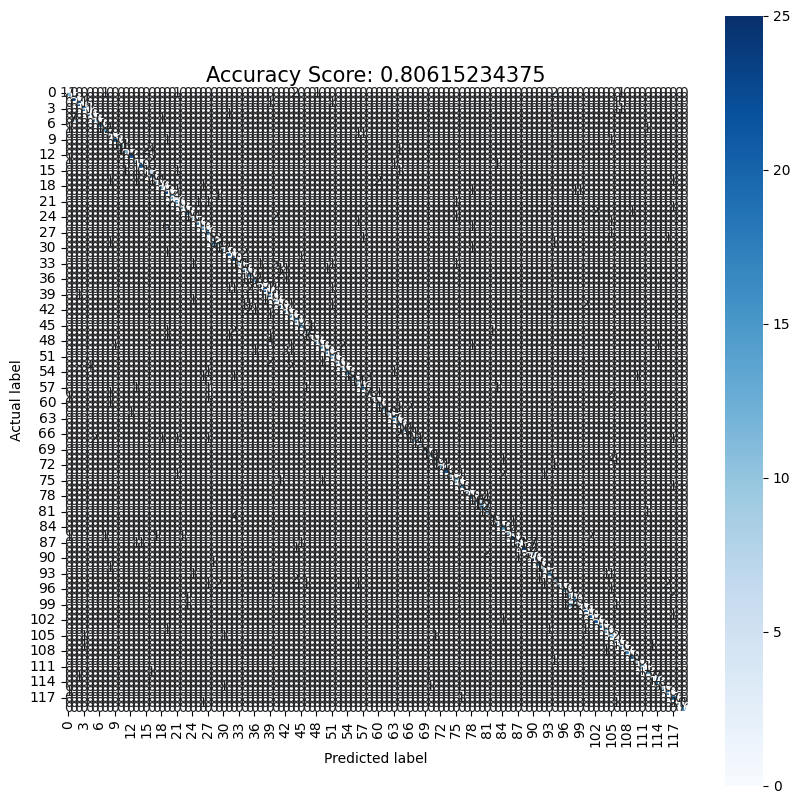

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
#Looking confusion matrix's view.
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square=True, cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'Accuracy Score: {0}'.format(test_accuracy)
plt.title(title, size = 15)
plt.show()

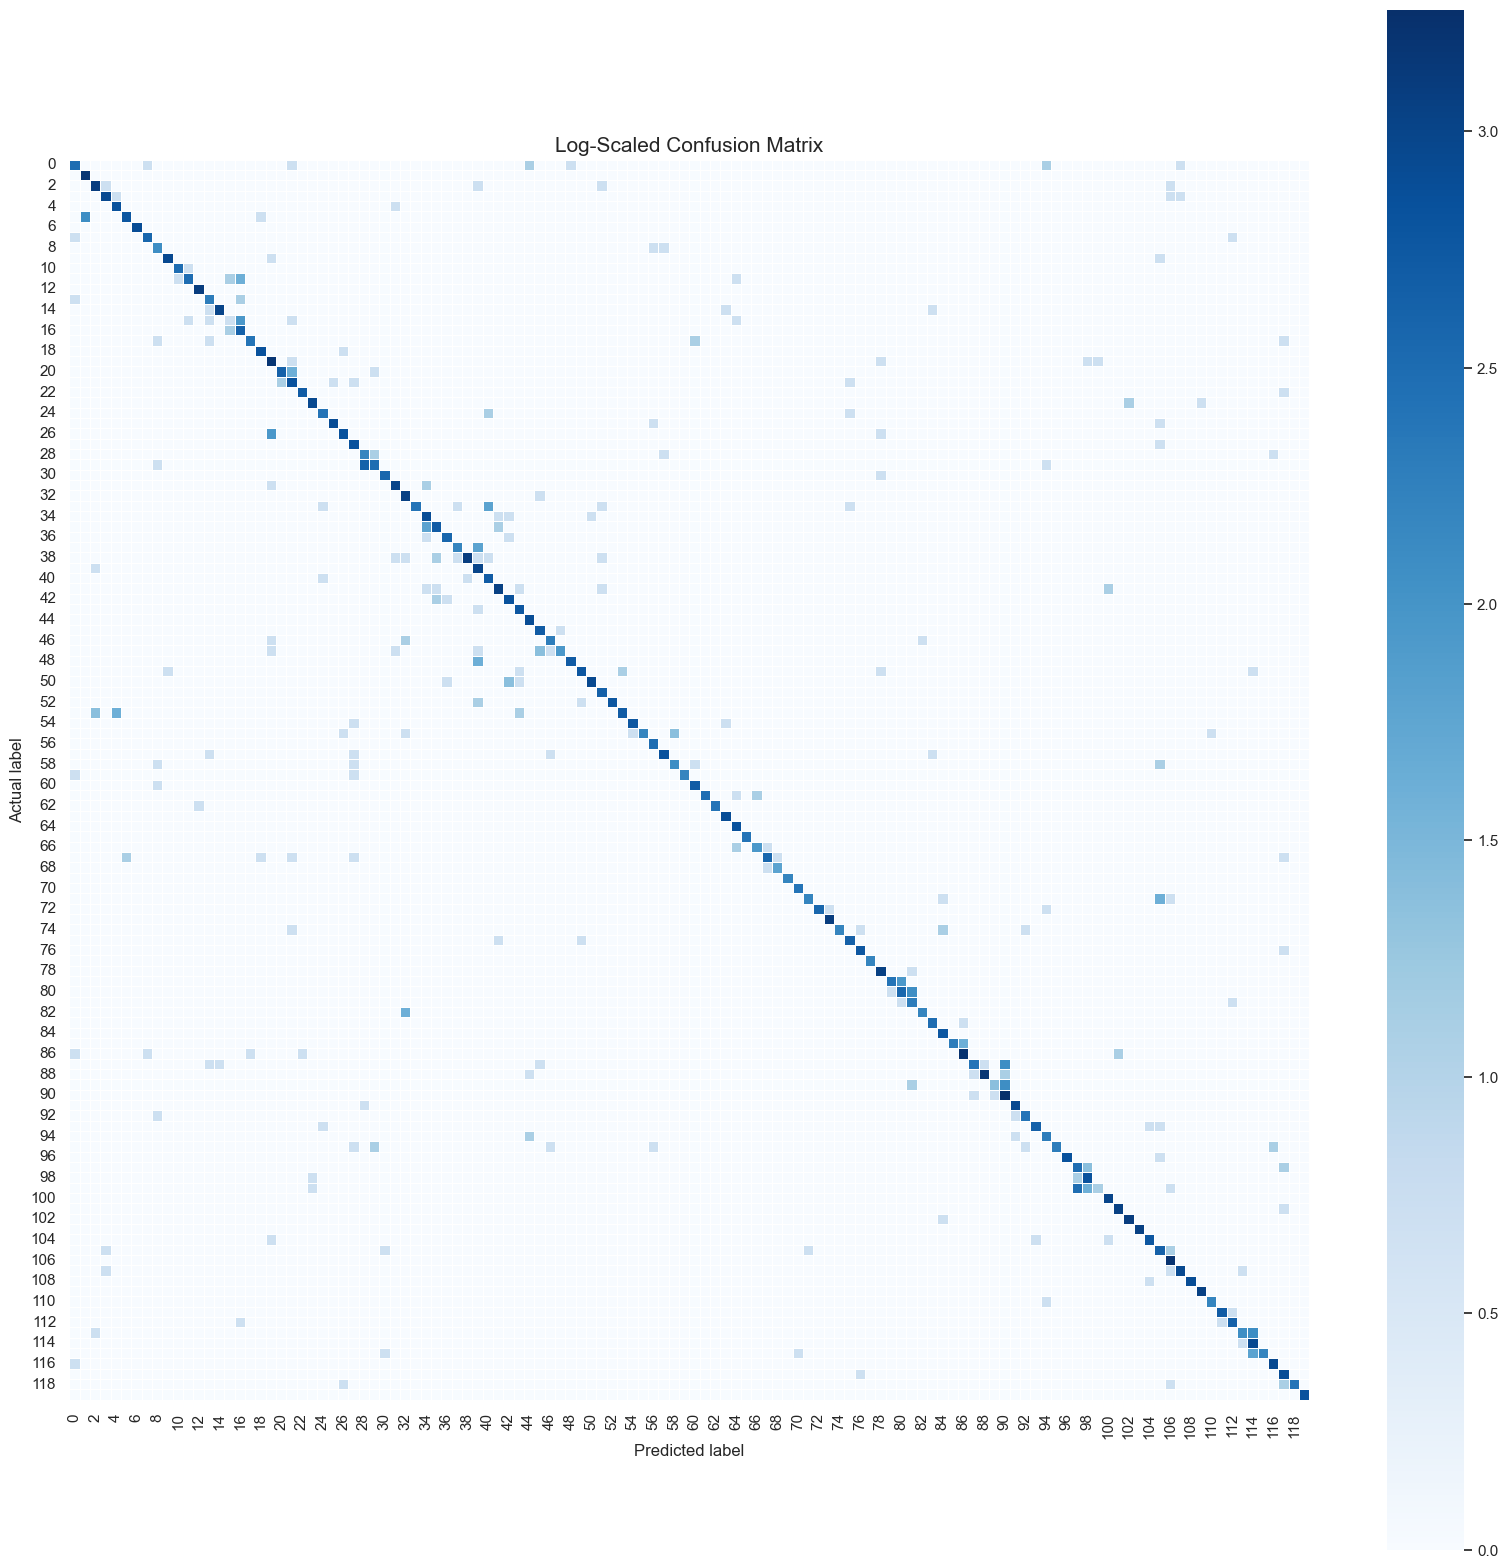

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Convert them to log & Add 1 to avoid log(0) which cannot be defined
cm_log = np.log(cm + 1)

plt.figure(figsize=(20,20)) 
sns.heatmap(cm_log, annot=False, fmt=".1f", linewidths=.5, square=True, cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Log-Scaled Confusion Matrix', size = 15)
plt.show()

5. Write-up:
There are lots of challenges before I got the final result. During the model selection. I tested all model that we learned in the class, but the results is pretty bad since most results closes to 0.01. The best performance is custom_model, but it shows overfitting because test accuracy only has 0.02. After that, I realize that there should be some points that I need to cosider.
First of all, the image might be flipped or with other factors that influnced the image prediction, so I adjust them as the image augmentation. However, the results were still bad. 
Secondly, I used Dropout to solve the overfitting, the accuracy of train and validation were going down sharply. I realized that it should not be a good way to solve it.
After that, I started to think about if the problem is the models which I selected. Compared among models, I found the inceptionNetV2 is the highest value even if it has around 0.15, so I tried to optimize based on the InceptionNetV2. The result was still not going well. 
After that, I tried to search online which the model has a good performance for predicting image. MobileNetV2 is what I found, and I put it into the model that was based on the InceptionNet V2 model.
EarlyStopping helps me catching the best performance of model. The accuracy of train, validation have a good performance, and the accuracy of test can reach 80% which shows that there probably is no overfitting. 
As for the confusion matrix, the initial graph didn't show well because there are so many labels in the stanford dogs dataset, and I used log-scaled to clearly reveal the confusion matrix again. Based on the final graph of confusion matrix view, it can be seen the diagonal line is significant which shows that the majority of classes have been correctly classified. 

